In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2024-04-24 02:29:40.769844: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Specify each path

In [2]:
import os
os.chdir("../..")
os.getcwd()

'/root/hand-gesture-recognition-mediapipe'

In [3]:
dataset = 'model/fine_tune_keypoint_classifier/keypoint.csv'
classes_path = 'model/fine_tune_keypoint_classifier/keypoint_classifier_label.csv'
model_save_path = 'model/fine_tune_keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/fine_tune_keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [43]:
NUM_CLASSES = 18

# Dataset reading

In [44]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [45]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [47]:
classes = np.loadtxt(classes_path, delimiter=',', dtype='str')

# Model building

In [48]:
from tensorflow.keras.layers import Input, Dense, Dropout

model = tf.keras.models.Sequential([
    Input((21 * 2, )),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

In [49]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               11008     
                                                                 
 dense_11 (Dense)            (None, 512)               131584    
                                                                 
 dense_12 (Dense)            (None, 1024)              525312    
                                                                 
 dense_13 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 18)                18450     
                                                                 
Total params: 1,735,954
Trainable params: 1,735,954
No

In [51]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
logs_path = "model/fine_tune_keypoint_classifier/log"
if not os.path.exists(log_path):
    os.mkdir(log_path)
cm_callback = tf.keras.callbacks.TensorBoard(
            log_dir=logs_path,
            update_freq='batch',
            profile_batch=0)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=100, verbose=1)

In [52]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [53]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=2048,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, cm_callback, es_callback]
)

Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 2.8913 - accuracy: 0.0499
Epoch 1: saving model to model/fine_tune_keypoint_classifier/keypoint_classifier.hdf5
1/1 [==============================] - 1s 792ms/step - loss: 2.8913 - accuracy: 0.0499 - val_loss: 2.8720 - val_accuracy: 0.1015
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 2.8652 - accuracy: 0.1354
Epoch 2: saving model to model/fine_tune_keypoint_classifier/keypoint_classifier.hdf5
1/1 [==============================] - 0s 144ms/step - loss: 2.8652 - accuracy: 0.1354 - val_loss: 2.8524 - val_accuracy: 0.1548
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 2.8381 - accuracy: 0.1920
Epoch 3: saving model to model/fine_tune_keypoint_classifier/keypoint_classifier.hdf5
1/1 [==============================] - 0s 149ms/step - loss: 2.8381 - accuracy: 0.1920 - val_loss: 2.8223 - val_accuracy: 0.1701
Epoch 4/1000
1/1 [==============================] - ETA: 0s - loss: 2.802

In [54]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

4/4 [==============================] - 0s 3ms/step - loss: 1.2705 - accuracy: 0.7868


In [55]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [56]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 142ms/step
[2.6658648e-11 4.2328413e-15 8.5974858e-13 2.3497558e-04 6.3870587e-14
 1.1585976e-10 1.6500705e-09 6.9303563e-16 4.4499485e-10 3.7083036e-18
 6.7640431e-09 5.3516973e-09 1.4550558e-06 8.9601257e-05 9.9967062e-01
 1.2305863e-09 1.2617575e-09 3.3294079e-06]
14


# Confusion matrix

13/13 [==============================] - 0s 1ms/step


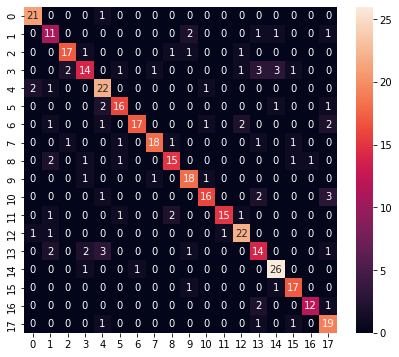

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        22
           1       0.58      0.69      0.63        16
           2       0.85      0.81      0.83        21
           3       0.70      0.54      0.61        26
           4       0.71      0.85      0.77        26
           5       0.80      0.80      0.80        20
           6       0.94      0.71      0.81        24
           7       0.90      0.78      0.84        23
           8       0.79      0.71      0.75        21
           9       0.78      0.86      0.82        21
          10       0.84      0.73      0.78        22
          11       0.94      0.75      0.83        20
          12       0.81      0.88      0.85        25
          13       0.58      0.61      0.60        23
          14       0.81      0.93      0.87        28
          15       0.81      0.89      0.85        19
          16       0.92      0.80      0.86        15
     

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [58]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [59]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpk96jdi3i/assets


INFO:tensorflow:Assets written to: /tmp/tmpk96jdi3i/assets
2024-04-24 04:16:13.808404: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-04-24 04:16:13.808447: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-04-24 04:16:13.808832: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpk96jdi3i
2024-04-24 04:16:13.812283: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-04-24 04:16:13.812325: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpk96jdi3i
2024-04-24 04:16:13.823301: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-04-24 04:16:13.926824: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpk96jdi3i
2024-04-24 04:16:13.952988: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

1747600

# Inference test

In [60]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [61]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [62]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [63]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 929 µs, sys: 323 µs, total: 1.25 ms
Wall time: 628 µs


In [64]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.9591645e-11 4.5304608e-15 1.1514969e-12 2.1665216e-04 6.6762568e-14
 1.1007073e-10 1.8304107e-09 7.0299584e-16 2.8947716e-10 3.5847448e-18
 5.1046323e-09 5.4410609e-09 1.4592786e-06 9.1067908e-05 9.9968851e-01
 1.4671031e-09 1.1548308e-09 2.3205375e-06]
14
